# Analyze Model Behvaiour of 3D Segmentation

Consider to download this Jupyter Notebook and run locally, or test it with Colab.
<br>
[![Download](https://img.shields.io/badge/Download-jupyter-blue)](https://github.com/ZerojumpLine/MOVAL/blob/main/docs/source/demos/analysis_seg3d.ipynb)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1_jU3umIceF-QyT25fI9G9BpK21es_2Wu#scrollTo=b04a1cbe-baeb-4fa9-8644-c73eb4d1ea98)

* In this notebook, we will show how to analyze the model behaviour based using MOVAL for 3D segmentation tasks.
<br>
* We provide the model predicted 3D segmentation results (network logits) for this tutorial, which will be download automatically. We also provide the model training code in https://github.com/ZerojumpLine/Robust-Medical-Segmentation.
<br>
* More specifically, we show an example of analyzing model behaviour under domain shifts on Prostate MRI segmentation based on a 3D U-Net. We will utilize the calculated logits on test dataset acquired with a different scanner.
<br>
* We will visualize the calibrated confidence scores as an proper indication of missegmentation.

In [1]:
!pip install moval
!pip install seaborn
!pip install pandas
!pip install tqdm
!pip install matplotlib
!pip install nibabel
!pip install scikit-image

In [2]:
import os
import gdown
import itertools
import zipfile
import pandas as pd
import numpy as np
import nibabel as nib
import moval
from moval.solvers.utils import ComputMetric
from tqdm import tqdm
import seaborn as sns
from skimage.transform import resize
import matplotlib.pyplot as plt

In [3]:
print(f"The installed MOVAL verision is {moval.__version__}")
print(f"The installed seaborn verision is {sns.__version__}")

The installed MOVAL verision is 0.2.16
The installed seaborn verision is 0.12.0


## Load the data

In [4]:
# download the data, which we used for MICCAI 2022

output = "data_moval.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=139pqxkG2ccIFq6qNArnFJWQ2by2Spbxt&export=download"
    output = "data_moval.zip"
    gdown.download(url, output, quiet=False)

directory_data = "data_moval"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [5]:
# download the coresponding image data

output = "img_prostate.zip"
if not os.path.exists(output):
    url = "https://drive.google.com/u/0/uc?id=1_zfIZ6aM6X3qtFjpO1BiYS7LKBxpfJ_r&export=download"
    output = "img_prostate.zip"
    gdown.download(url, output, quiet=False)

directory_data = "img_prostate"
if not os.path.exists(directory_data):
    with zipfile.ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall(directory_data)

In [6]:
ls

analysis_cls.ipynb    data_moval_supp.zip   img_cifar/
analysis_seg2d.ipynb  estim_cls.ipynb       img_cifar.zip
analysis_seg3d.ipynb  estim_seg2d.ipynb     img_prostate/
data_moval/           estim_seg3d.ipynb     img_prostate.zip
data_moval.zip        img_cardiac/
data_moval_supp/      img_cardiac.zip


In [7]:
# now I am playing with prostate segmentation
Datafile_eval = "data_moval/Prostateresults/seg-eval.txt"
Imglist_eval = open(Datafile_eval)
Imglist_eval_read = Imglist_eval.read().splitlines()

logits = []
gt = []
# to accelerate the debugging speed, crop the middel 60 x 60 x 30 cub for training/inference.
for Imgname_eval in Imglist_eval_read:
    GT_file = Imgname_eval.replace("data", "data_moval")
    caseID = Imgname_eval.split("/")[-1][:6]
    logit_cls0_file = "data_moval/Prostateresults/prostateval/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval/Prostateresults/prostateval/results/pred_" + caseID + "cls1_prob.nii.gz"
    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls0      = logit_cls0_read.get_fdata()   # ``(H, W, D)``
    logit_cls1      = logit_cls1_read.get_fdata()
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H, W, D)``
    logit_cls0      = logit_cls0[logit_cls0.shape[0] //2 - 30: logit_cls0.shape[0] //2 + 30,
                                 logit_cls0.shape[1] //2 - 30: logit_cls0.shape[1] //2 + 30,
                                 logit_cls0.shape[2] //2 - 15: logit_cls0.shape[2] //2 + 15]
    logit_cls1      = logit_cls1[logit_cls1.shape[0] //2 - 30: logit_cls1.shape[0] //2 + 30,
                                 logit_cls1.shape[1] //2 - 30: logit_cls1.shape[1] //2 + 30,
                                 logit_cls1.shape[2] //2 - 15: logit_cls1.shape[2] //2 + 15]
    GTimg           = GTimg[GTimg.shape[0] //2 - 30: GTimg.shape[0] //2 + 30,
                            GTimg.shape[1] //2 - 30: GTimg.shape[1] //2 + 30,
                            GTimg.shape[2] //2 - 15: GTimg.shape[2] //2 + 15]
    logit_cls = np.stack((logit_cls0, logit_cls1))  # ``(d, H, W, D)``
    logits.append(logit_cls)
    gt.append(GTimg)

# logits is a list of length ``n``,  each element has ``(d, H, W, D)``. 
# gt is a list of length ``n``,  each element has ``(H, W, D)``.
# H, W and D could differ for different cases.

Datafile_test = "data_moval/Prostateresults/seg-testA.txt"
Imglist_test = open(Datafile_test)
Imglist_test_read = Imglist_test.read().splitlines()

logits_test = []
gt_test = []
imgs_test = []
for Imgname_test in Imglist_test_read:
    GT_file = Imgname_test.replace("data", "data_moval")

    caseID = Imgname_test.split("/")[-1][:6]

    logit_cls0_file = "data_moval/Prostateresults/prostattestcondition_A/results/pred_" + caseID + "cls0_prob.nii.gz"
    logit_cls1_file = "data_moval/Prostateresults/prostattestcondition_A/results/pred_" + caseID + "cls1_prob.nii.gz"

    logit_cls0_read = nib.load(logit_cls0_file)
    logit_cls1_read = nib.load(logit_cls1_file)
    logit_cls0      = logit_cls0_read.get_fdata()
    logit_cls1      = logit_cls1_read.get_fdata()
   
    img_file = f"img_prostate/img_prostate/test/{caseID}/image.nii.gz"
    img_read = nib.load(img_file)
    img_data      = img_read.get_fdata()   # ``(H, W, D)``
    
    GT_read         = nib.load(GT_file)
    GTimg           = GT_read.get_fdata()           # ``(H', W', D')``

    img_data = resize(img_data, GTimg.shape, mode='constant')
    logit_cls = np.stack((logit_cls0, logit_cls1))  # ``(n', H', W', D')``
    
    logits_test.append(logit_cls)
    gt_test.append(GTimg)
    imgs_test.append(img_data)


# logits_test is a list of length ``n'``,  each element has ``(d, H', W', D')``. 
# gt_test is a list of length ``n'``,  each element has ``(H', W', D')``.
# H, W and D could differ for different cases.

In [8]:
print(f"The validation predictions, ``logits`` are a list of length {len(logits)} each element has approximately {logits[0].shape}")
print(f"The validation labels, ``gt`` are a list of length {len(gt)}, each element has approximately {gt[0].shape}\n")
print(f"The test predictions, ``logits_test`` are a list of length {len(logits_test)} each element has approximately {logits_test[0].shape}")
print(f"The test labels, ``gt_test`` are a list of length {len(gt_test)}, each element has approximately {gt_test[0].shape}")
print(f"The test images, ``imgs_test`` are a list of length {len(imgs_test)}, each element has approximately {imgs_test[0].shape}")

The validation predictions, ``logits`` are a list of length 10 each element has approximately (2, 60, 60, 30)
The validation labels, ``gt`` are a list of length 10, each element has approximately (60, 60, 30)

The test predictions, ``logits_test`` are a list of length 2 each element has approximately (2, 256, 256, 40)
The test labels, ``gt_test`` are a list of length 2, each element has approximately (256, 256, 40)
The test images, ``imgs_test`` are a list of length 2, each element has approximately (256, 256, 40)


## MOVAL estimation

In [9]:
moval_options = []
moval_options.append(['ac-model', 'segmentation', 'max_class_probability-conf', False])
moval_options.append(['ts-model', 'segmentation', 'max_class_probability-conf', False])
moval_options.append(['ts-model', 'segmentation', 'max_class_probability-conf', True])
moval_options.append(['ts-atc-model', 'segmentation', 'entropy-conf', True])

In [10]:
def test_cls(estim_algorithm, mode, confidence_scores, class_specific, logits, gt, logits_tests, gt_tests):
    """Test MOVAL with different conditions for segmentation tasks
        
    Args:
        mode (str): The given task to estimate model performance.
        confidence_scores (str):
            The method to calculate the confidence scores. We provide a list of confidence score calculation methods which 
            can be displayed by running :py:func:`moval.models.get_conf_options`.
        estim_algorithm (str):
            The algorithm to estimate model performance. We also provide a list of estimation algorithm which can be displayed by
            running :py:func:`moval.models.get_estim_options`.
        class_specific (bool):
            If ``True``, the calculation will match class-wise confidence to class-wise accuracy.
        logits: The network output (logits) of a list of n ``(d, H, W, (D))`` for segmentation. 
        gt: The cooresponding annotation of a list of n ``(H, W, (D))`` for segmentation.
        logits_tests:  The network testing output (logits) of a list of n' ``(d, H', W', (D'))`` for segmentation. 
        gt_test: The cooresponding testing annotation of a list of n' ``(H', W', (D'))`` for segmentation.

    Returns:
        err_test (float): testing error.
        moval_model: Optimized moval model.

    """
    
    moval_model = moval.MOVAL(
                mode = mode,
                metric = "f1score",
                confidence_scores = confidence_scores,
                estim_algorithm = estim_algorithm,
                class_specific = class_specific,
                approximate = True,
                approximate_boundary = 10
                )

    #
    moval_model.fit(logits, gt)

    # save the test err in the result files.

    estim_dsc_test = moval_model.estimate(logits_test)

    return moval_model

In [11]:
moval_model_MCP = test_cls(
        estim_algorithm = moval_options[0][0], 
        mode = moval_options[0][1], 
        confidence_scores = moval_options[0][2],
        class_specific = moval_options[0][3],
        logits = logits,
        gt = gt,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
#
moval_model_baseline = test_cls(
        estim_algorithm = moval_options[1][0], 
        mode = moval_options[1][1], 
        confidence_scores = moval_options[1][2],
        class_specific = moval_options[1][3],
        logits = logits,
        gt = gt,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
#
moval_model_cs = test_cls(
        estim_algorithm = moval_options[2][0], 
        mode = moval_options[2][1], 
        confidence_scores = moval_options[2][2],
        class_specific = moval_options[2][3],
        logits = logits,
        gt = gt,
        logits_tests = logits_test,
        gt_tests = gt_test
    )
#
moval_model_cs_entropy = test_cls(
        estim_algorithm = moval_options[3][0], 
        mode = moval_options[3][1], 
        confidence_scores = moval_options[3][2],
        class_specific = moval_options[3][3],
        logits = logits,
        gt = gt,
        logits_tests = logits_test,
        gt_tests = gt_test
    )

Starting optimizing for model ac-model with confidence max_class_probability-conf based on metric f1score, class specific is False.
Calculating and saving the fitted case-wise performance...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric f1score, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric accuracy, class specific is False.
Opitimizing with 10 samples...
Be patient, it should take a while...
Starting optimizing for model ts-model with confidence max_class_probability-conf based on metric f1score, class specific is True.
Opitimizing with 10 samples...
Be patient, it should take a while...
Calculating and saving the fitted case-wise performance...
Starting optimizing for model ts-atc-model with confidence entropy-conf based on metric 

## Get the confidence scores

In [12]:
conf_mcp = moval_model_MCP.model_.calibrate(logits_test) # n list of (H, W, D)
conf_baseline = moval_model_baseline.model_.calibrate(logits_test)  # n list of (H, W, D)
conf_cs = moval_model_cs.model_.calibrate(logits_test)  # n list of (H, W, D)
conf_cs_entropy = moval_model_cs_entropy.model_.calibrate(logits_test)  # n list of (H, W, D)

In [13]:
def caculate_dsc(score, inp, gt):
    """Calculate real dsc and estimated dsc

    Args:
        score: Confidence scores of a list of n ``(H, W, (D))``.
        inp: Network output of a list of n ``(d, H, W, (D))``
        gt: Ground truth segmentation of a list of n ``(H, W, (D))``.

    Return:
        estim_dsc: The mean estimated DSC for cases of shape ``(n,)``.
        real_dsc: The mean real DSC of for cases shape ``(n,)``.
    
    """
    from moval.models.utils import SoftDiceLoss    
    num_class = inp[0].shape[0]
    estim_dsc_list = []
    #
    pred_all_flatten_bg = []
    gt_all_flatten_bg = []
    dsc = []    
    for n_case in range(len(inp)):
        pred_case = np.argmax(inp[n_case], axis = 0) # ``(H, W, (D))``
        pred_flatten = pred_case.flatten() # ``n``
        score_case = score[n_case] # ``(H, W, (D))``
        score_flatten = score[n_case].flatten() # ``n``
        score_filled = np.zeros((score_flatten.shape + (num_class,))) # ``(n, d)``
        score_filled[np.arange(score_filled.shape[0]), pred_flatten] = score_flatten # ``(n, d)``
        score_filled = score_filled.T # ``(d, n)``
        score_filled = score_filled.reshape(((num_class,) + score_case.shape)) # ``(d, H, W, (D))``
        #
        estim_dsc = SoftDiceLoss(score_filled[np.newaxis, ...], pred_case[np.newaxis, ...])

        #
        gt_case     = gt[n_case] # ``(H, W, (D))``
        pos_bg = np.where(pred_case.flatten() == 0)[0]

        pred_all_flatten_bg.append(pred_case.flatten()[pos_bg])
        gt_all_flatten_bg.append(gt_case.flatten()[pos_bg])

        dsc_case = np.zeros(inp[n_case].shape[0])
        for kcls in range(1, inp[n_case].shape[0]):
            if np.sum(gt_case == kcls) == 0:
                estim_dsc[kcls] = -1
                dsc_case[kcls] = -1
            else:
                dsc_cal, _, _ = ComputMetric(pred_case == kcls, gt_case == kcls)
                dsc_case[kcls] = dsc_cal

        estim_dsc_list.append(np.mean(estim_dsc[1:][dsc_case[1:] >= 0]))
        dsc.append(np.mean(dsc_case[1:][dsc_case[1:] >= 0]))

    return estim_dsc_list, dsc

In [14]:
estim_dsc_mcp, dsc_mcp = caculate_dsc(conf_mcp, logits_test, gt_test)

## Make the 3D scatter plot

In [15]:
def make_3d_plot(conf_map_0, img_toshow, gt_toshow, pred_toshow, _real_dsc, _estim_dsc, title = 'The Visualization of MCP'):
    """Visualization of confidence score using 3D scatter plot.
    
    Args:
        conf_map_0: The calculated 3D confidence maps, of shape ``(H, W, D)``.
        img_toshow: An example 2D image, of shape ``(H, W)``.
        gt_toshow: The corresponding 3D label map, of shape ``(H, W, D)``.
        pred_toshow:The corresponding 3D prediction, of shape ``(H, W, D)``.
        _real_dsc (float): The real DSC calculated by the 3D volume.
        _estim_dsc (float): The esimtaed DSC.
        title: The given title to be shown.
    
    """

    # Set up the 3D plot
    import matplotlib.patches as mpatches
    
    sns.set_style("white")
    fig, axes = plt.subplots(1, 3, figsize=(15, 8), subplot_kw={'projection': '3d', 'computed_zorder': False})
    
    fig.subplots_adjust(wspace=0.)  # Adjust the value as needed
    
    # Define a threshold for filtering out small values
    threshold = 0.1  # Adjust as needed
    # Plot each 2D scatter plot as a separate layer
    for i in range(conf_map_0.shape[2]):
        x, y = np.meshgrid(np.arange(conf_map_0.shape[0]), np.arange(conf_map_0.shape[1]))
        z = conf_map_0[:, :, i]
        # Filter out small values
        mask = z > threshold
        x = x[mask]
        y = y[mask]
        z = z[mask]
        axes[2].scatter(x, y, i * np.ones_like(x), c='#99687f', alpha=0.05, zorder=1)
    # Get the maximum z value from the scatter plot
    max_z_scatter = 0
    # Show the image on the bottom x-y plane
    x, y = np.meshgrid(np.arange(img_toshow.shape[0]), np.arange(img_toshow.shape[1]))
    axes[2].plot_surface(x, y, max_z_scatter * np.ones_like(img_toshow), facecolors=plt.cm.gray(img_toshow), rstride=5, cstride=5, shade=False, zorder=0)
    # Remove tick lines and labels
    axes[2].set_title('Confidence Score')
    
    
    # Plot each 2D scatter plot as a separate layer
    for i in range(conf_map_0.shape[2]):
        x, y = np.meshgrid(np.arange(conf_map_0.shape[0]), np.arange(conf_map_0.shape[1]))
        z = gt_toshow[:, :, i]
        # Filter out small values
        mask = z == 1
        x = x[mask]
        y = y[mask]
        z = z[mask]
    
        axes[0].scatter(x, y, i * np.ones_like(x), c='green', alpha=0.05, zorder=1)
    # Show the image on the bottom x-y plane
    x, y = np.meshgrid(np.arange(img_toshow.shape[0]), np.arange(img_toshow.shape[1]))
    axes[0].plot_surface(x, y, max_z_scatter * np.ones_like(img_toshow), facecolors=plt.cm.gray(img_toshow), rstride=5, cstride=5, shade=False, zorder=0)
    axes[0].set_title('Image Overlapped with Ground Truth')
    
    # Define a threshold for filtering out small values
    # Plot each 2D scatter plot as a separate layer
    for i in range(conf_map_0.shape[2]):
        x, y = np.meshgrid(np.arange(conf_map_0.shape[0]), np.arange(conf_map_0.shape[1]))
        z = np.abs(pred_toshow[:, :, i] - gt_toshow[:, :, i])
        # Filter out small values
        mask = z == 1
        x = x[mask]
        y = y[mask]
        z = z[mask]
        axes[1].scatter(x, y, i * np.ones_like(x), c='#99687f', alpha=0.5, zorder=1)
    # Show the image on the bottom x-y plane
    x, y = np.meshgrid(np.arange(img_toshow.shape[0]), np.arange(img_toshow.shape[1]))
    axes[1].plot_surface(x, y, max_z_scatter * np.ones_like(img_toshow), facecolors=plt.cm.gray(img_toshow), rstride=5, cstride=5, shade=False, zorder=0)
    axes[1].set_title('Absolute Error between Prediction and Ground Truth')
    
    for k_axis in range(3):
        axes[k_axis].set_xticks([])
        axes[k_axis].set_yticks([])
        axes[k_axis].set_zticks([])
        axes[k_axis].set_xticklabels([])
        axes[k_axis].set_yticklabels([])
        axes[k_axis].set_zticklabels([])
        axes[k_axis].set_xlim(0, 255)
        axes[k_axis].set_ylim(0, 255)
        axes[k_axis].xaxis.set_pane_color((0.850, 0.816, 0.686))
        axes[k_axis].yaxis.set_pane_color((0.850, 0.816, 0.686))
        axes[k_axis].zaxis.set_pane_color((0.850, 0.816, 0.686))

        axes[k_axis].grid(False)
    
    alpha_patch = mpatches.Patch(color='#99687f', alpha = 0.5, label='The regions with low confidence score')
    red_patch = mpatches.Patch(color='#99687f', label='The segmentation error')
    green_patch = mpatches.Patch(color='green', label='The ground truth label')
    axes[0].legend(handles=[green_patch], bbox_to_anchor=(0.25, 0.05), loc='upper left')
    axes[1].legend(handles=[red_patch], bbox_to_anchor=(0.25, 0.05), loc='upper left')
    axes[2].legend(handles=[alpha_patch], bbox_to_anchor=(0.15, 0.05), loc='upper left')

    axes[1].text2D(0.5, 0.96,  f'Real DSC is {_real_dsc:.3f}', transform=axes[1].transAxes, ha='center', va='center', fontsize=12)
    axes[2].text2D(0.5, 0.96,  f'Estimated DSC is {_estim_dsc:.3f}', transform=axes[2].transAxes, ha='center', va='center', fontsize=12)
    
    fig.suptitle(title, fontsize=16, y=0.82)
    # Show the plot
    plt.show()

In [16]:
conf_mcp_0 = 1-conf_mcp[0]
img_toshow = imgs_test[0][:,:,20]
gt_toshow = gt_test[0]
pred_toshow = np.argmax(logits_test[0], axis=0)
img_toshow = (img_toshow - np.min(img_toshow)) / (np.max(img_toshow) - np.min(img_toshow))
_estim_dsc = estim_dsc_mcp[0]
_real_dsc = dsc_mcp[0]

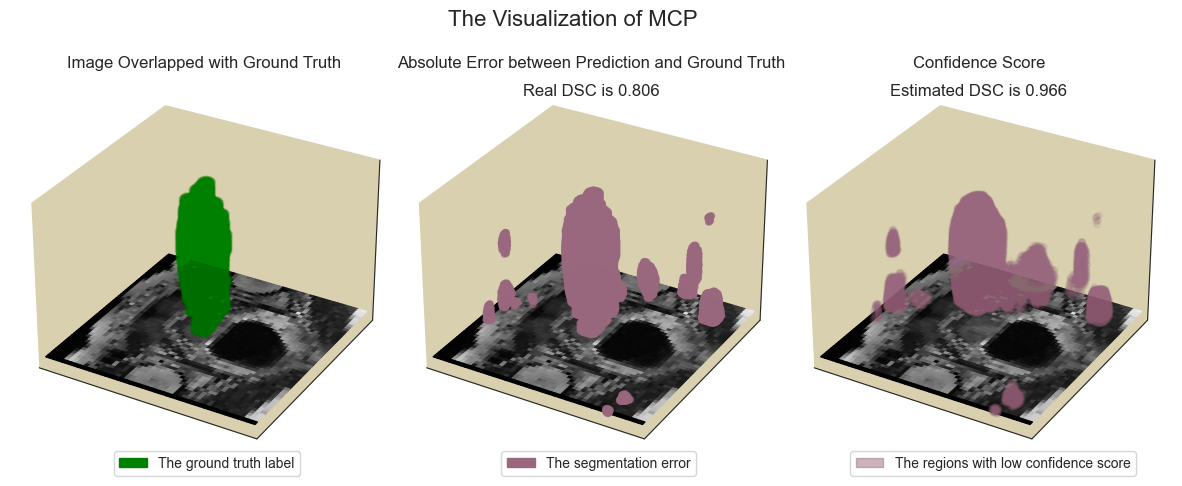

In [17]:
make_3d_plot(conf_mcp_0, img_toshow, gt_toshow, pred_toshow, _real_dsc, _estim_dsc, title = 'The Visualization of MCP')